In [ ]:
#TODO track history of tuner models
#https://github.com/keras-team/keras-tuner/issues/120

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import pandas as pd
import numpy as np
from keras_preprocessing.image import ImageDataGenerator


In [2]:
#NOTE - I am working in an nvidia-docker image with official tensorflow docker.
# I had to add this line AND 'trust' the notebook on top-right. Otherwise an ugly
# cudNN error is present.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [17]:
def make_generators(image_size,
                    top6_train,
                    top6_valid,
                    y_target,
                    batch_size=1):
    
    datagen=ImageDataGenerator(rescale=1./255)
    train_generator=datagen.flow_from_dataframe(dataframe=top6_train,
                                            directory="/tf/beetleData/images",
                                            x_col="Filename:", y_col=y_target,
                                            class_mode="categorical",
                                            target_size=image_size,
                                            batch_size=batch_size)
    validation_generator=datagen.flow_from_dataframe(dataframe=top6_valid,
                                            directory="/tf/beetleData/images",
                                            x_col="Filename:", y_col= y_target,
                                            class_mode="categorical",
                                            target_size=image_size,
                                            batch_size=batch_size,
                                                    shuffle=False)
    
    return train_generator, validation_generator

In [18]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    #x = data_augmentation(inputs)

    # Entry block
    #x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inpu)
        # This is done already because we used an ImageDataGenerator
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [19]:
def train_class(model,
                epochs=10,
               label_smooth=False,
               class_weights=True,
               ):
    from sklearn.utils import class_weight

    callbacks = [
        keras.callbacks.ModelCheckpoint("/tf/beetleData/fam_10_58x58.h5",
                                       save_best_only = True),
    ]
    
    if label_smooth:
        loss = keras.losses.CategoricalCrossentropy(label_smoothing=label_smooth)
    else:
        loss = 'categorical_crossentropy'
    
    #LABEL_SMOOTHING BLOCK
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=loss,
        metrics=["accuracy"],
)
    
    y_train = train_generator.classes
    
    
    #CLASS_WEIGHTS BLOCK
    if class_weights:
        c_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(y_train),
                                                     np.array(y_train))
        class_weight_dict = dict(enumerate(c_weights))
        
        
        
    #Fit the model - based on conditions
        history58x58 = model.fit(
            train_generator,validation_data=validation_generator,epochs=epochs,callbacks = [callbacks]
            #    train_generator,validation_data=validation_generator,epochs=epochs, callbacks=callbacks
        )
        return history58x58
    else:
        history58x58 = model.fit(
        train_generator,validation_data=validation_generator,epochs=epochs ,callbacks = [callbacks]
        #    train_generator,validation_data=validation_generator,epochs=epochs, callbacks=callbacks
    )
        return history58x58

In [20]:
def csvSplitter(dataframe, split_ratio):
    """
    To use the data generator in keras with flow_from_dataset, you need a helper function to perform the train/test
    split.
    
    Input: a pandas CSV/Table of all your data.
    Output : the same dataframe, split into seperate training/validation dataframes, to be used in rest of pipeline
    """
    dataframe = dataframe.sample(frac=1).reset_index(drop=True) #Shuffles DataFrame - for a lazy way to test/train split
    validation_index = round(dataframe.shape[0] * split_ratio) # Gets row # of images in validation set 
    training_index = dataframe.shape[0] - validation_index # Gets row # of images in training set
    train_valid_split = np.concatenate((np.ones(validation_index),np.zeros(training_index))) # creates train-valid column
    dataframe['trainValid'] = train_valid_split # adds the splitting ID to the dataframe
    train_df = dataframe[dataframe['trainValid'] == 0.0] #subsetting based on previously created test/train split col
    valid_df = dataframe[dataframe['trainValid'] == 1.0]
    
    return train_df, valid_df


In [21]:
def get_beetle_labels(y_target = 'Family:',
                      data_dir = '/tf/beetleData/images/',
                      label_file = '/tf/beetleData/labels/master_rbi.csv',
                      top_classes = 6):
    """
    Read label file
    Get images from Dorsal View
    Take those images and use csvsplitter
    Return train and test dataframes
    """
    labels = pd.read_csv(label_file)
    assert y_target in labels.columns, "y_target should be a column in the label_file!"
    
    data_dir = pathlib.Path('/tf/beetleData/images/')
    dorsal_data = labels[labels["View:"] == "Dorsal"] #filter images that are from dorsal view
    dorsal_data[y_target].value_counts().sort_values().plot(kind = 'barh') # preview the distribution
    
    top6 = dorsal_data[y_target].value_counts(normalize=True)[:top_classes]
    print(top6)
    print('c1' + str(top6.shape))
    top6 = top6.index.values # get top 6 most common classes.
    top6_df = dorsal_data[dorsal_data[y_target].isin(top6)] #filter images from only top 6 classes
    top6_train, top6_valid = csvSplitter(top6_df, .2)
    #print(top6_train[y_target])
    #print(top6_valid[y_target])
    #failsafe -> make sure that no unique labels are exclusive to training or validation set
    overlap_labels = (list(set(top6_train[y_target]) & set(top6_valid[y_target])))
    top6_train = top6_train.loc[top6_train[y_target].isin(overlap_labels)]
    print(top6_valid.shape)
    top6_valid = top6_valid.loc[top6_valid[y_target].isin(overlap_labels)]
    print(top6_valid.shape)
    
    #Add a failsafe - > make sure no unique target labels are exclusively in training or validation
    print('loaded in training size of ' + str(top6_train.shape))
    
    return top6_train, top6_valid

Scarabaeidae     0.492287
Cerambycidae     0.241449
Lucanidae        0.100604
Buprestidae      0.069081
Carabidae        0.048625
Cicindelidae     0.030181
Geotrupidae      0.007042
Chrysomelidae    0.001677
Silphidae        0.001677
Curculionidae    0.001341
Name: Family:, dtype: float64
c1(10,)
(593, 9)
(593, 9)
loaded in training size of (2371, 9)
Found 2371 validated image filenames belonging to 10 classes.
Found 593 validated image filenames belonging to 10 classes.
Epoch 1/50


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[0 1 7 ... 8 7 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[6,8] labels_size=[6,10]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at <ipython-input-19-1e351392746f>:39) ]] [Op:__inference_train_function_65696]

Function call stack:
train_function


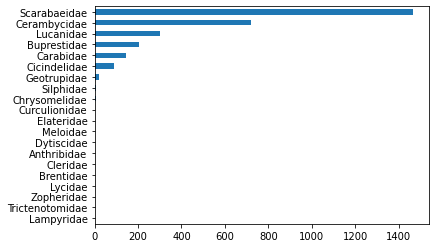

In [22]:
y_target='Family:'
top_classes = 10 # attempts to get 100 classes. but may be less if the labels are exclusive to test/valid
epochs = 50
label_smooth=0.1
image_size=(58,58)

tr, va = get_beetle_labels(y_target=y_target,
                      top_classes=top_classes) # top classes has to be oddly high (for any label
                                        # other than the family label, unsure why

assert sum(np.sort(va[y_target].unique()) == np.sort(tr[y_target].unique())) == len(va[y_target].unique()), \
    'Mismatched Labels?'
train_generator,  validation_generator  = make_generators(image_size, tr, va,y_target,batch_size=6)
class_labels = train_generator.class_indices
num_classes = len(np.unique(train_generator.classes))
#checkpoint_cb = tensorflow.keras.callbacks.ModelCheckPoint('my_keras_model.h5',
model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
history = train_class(model, epochs=epochs,label_smooth=.1, class_weights=True)


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[ 43   0   0   0   0   0   0   0   0   0]
 [  0  36   0   0   0   0   0   0   0   0]
 [  0   0 144   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0]
 [  0   0   1  17   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   2   0   0   0]
 [  0   0   0   0   0  57   0   0   0   0]
 [  0   0   0   0   0   0 287   0   0   0]
 [  0   0   1   0   0   0   1   0   0   0]]


In [24]:
print('Classification Report')
target_names =  list(train_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
               precision    recall  f1-score   support

  Buprestidae       1.00      1.00      1.00        43
    Carabidae       1.00      1.00      1.00        36
 Cerambycidae       0.98      1.00      0.99       144
Chrysomelidae       0.00      0.00      0.00         1
 Cicindelidae       0.00      0.00      0.00        18
Curculionidae       0.00      0.00      0.00         1
  Geotrupidae       0.01      0.50      0.01         4
    Lucanidae       0.00      0.00      0.00        57
 Scarabaeidae       0.00      0.00      0.00       287
    Silphidae       0.00      0.00      0.00         2

     accuracy                           0.38       593
    macro avg       0.30      0.35      0.30       593
 weighted avg       0.37      0.38      0.37       593



In [ ]:
pd.DataFrame(history.history['val_accuracy']).plot()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch


def build_model(hp):
    
    input_shape = (100,100)
    num_classes = 40
    
    inputs = keras.Input(shape=input_shape + (3,))
    # Image augmentation block
    #x = data_augmentation(inputs)

    # Entry block
    #x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inpu)
        # This is done already because we used an ImageDataGenerator
    x = layers.Conv2D(hp.Choice('first_layer', values=[128,256,512]), 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(hp.Choice('second_layer', values=[64,128,256,512]), 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(hp.Choice('dropout_final_layer',values=[0.05,0.02,0.0]))(x)
    outputs = layers.Dense(units, activation=activation)(x)
    
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-3, 1e-4, 1e-5])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='/tf/beetleData/',
    project_name='helloworld4')

In [ ]:
tuner.search(train_generator,
             epochs=10,
             validation_data= validation_generator)

In [ ]:
x = build_model(hp)

In [ ]:
train_generator.directory

In [ ]:
train_generator.filepaths

In [ ]:
tuner.tuner_id

In [ ]:
models = tuner.get_best_models(num_models=1)

In [ ]:
print(models[0].history)

In [ ]:
tuner.results_summary()

In [ ]:
models[0].evaluate(validation_generator)

In [ ]:
model.evaluate(validation_generator)